# Peak-Valley Method

In [29]:
import copy
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

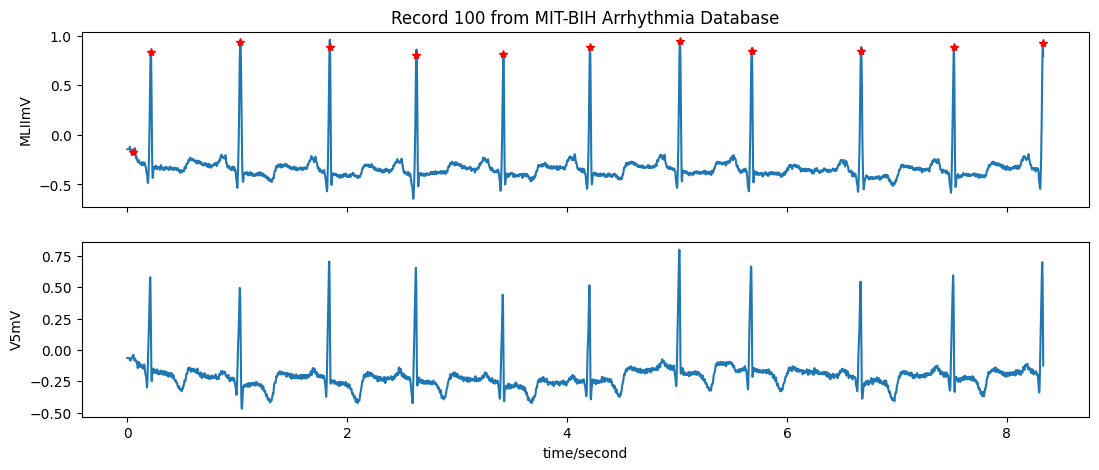

In [30]:
# Extract data from files

# Samples from the original data to load
SAMPLE_NUM = 3000

record = wfdb.rdrecord('src/mitdb/100', sampto = SAMPLE_NUM)
annotation = wfdb.rdann('src/mitdb/100', 'atr', sampto = SAMPLE_NUM)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')
#display(record.__dict__)
#display(annotation.__dict__)


In [31]:
# Extract ECG data array
v_data = record.p_signal
v_data = v_data[:,0]

# Define time array (Fs:360Hz)
v_time = np.arange(0, v_data.size, 1, dtype=int)
v_time = np.round(v_time/360, 3)

# Extract annotations array
v_ann = np.zeros(shape=(v_data.size,1), dtype=str)
for i in range(len(annotation.sample)):
    v_ann[(annotation.sample)[i]] = annotation.symbol[i]


In [32]:
# Calculate moving averages

# Window size for moving averages
MEAN_WINDOW = 50
LOWPASS_WINDOW = 5

v_mean = np.zeros_like(v_data)
v_data_lp = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

tmp_mean = moving_average(v_data,MEAN_WINDOW)
tmp_lowpass = moving_average(v_data, LOWPASS_WINDOW)

v_mean = np.pad(tmp_mean, (MEAN_WINDOW-1,0), 'constant', constant_values=(tmp_mean[0],0))
v_data_lp = np.pad(tmp_lowpass, (LOWPASS_WINDOW-1,0), 'constant', constant_values=(tmp_lowpass[0],0))

In [33]:
# Calculate derivative of each point of the data array

v_data_deriv = np.empty_like(v_data_lp)
v_data_deriv = np.gradient(v_data_lp)

In [34]:
# Identify potential peaks
# Based on derivative: 
#   1) der[i] = 0 AND sig[i] > mean[i]*COEFF
#   2) der[i-1] * der[i] < 0 AND (sig[i-1]+sig[i])/2 > COEFF*mean[i]

MEAN_OFFSET = 0.06
v_mean_coef_pos = np.add(v_mean, MEAN_OFFSET*np.ones_like(v_mean))
v_mean_coef_neg = np.add(v_mean, -MEAN_OFFSET*np.ones_like(v_mean))
#v_mean_coef_pos = np.add(v_mean, -MEAN_OFFSET*v_mean)
#v_mean_coef_neg = np.add(v_mean, MEAN_OFFSET*v_mean)


v_peaks = np.zeros_like(v_data)

for i in range(len(v_data_lp)):
    if    ((v_data_deriv[i] == 0) and (v_data_lp[i] > v_mean_coef_pos[i])) or \
          ((v_data_deriv[i] == 0) and (v_data_lp[i] < v_mean_coef_neg[i])) or \
          ((v_data_deriv[i]*v_data_deriv[i-1] < 0) and ((v_data_lp[i-1]+v_data_lp[i])/2 > v_mean_coef_pos[i])) or \
          ((v_data_deriv[i]*v_data_deriv[i-1] < 0) and ((v_data_lp[i-1]+v_data_lp[i])/2 < v_mean_coef_neg[i]))  :
        v_peaks[i] = v_data_lp[i]

v_peaks_x = v_time[v_peaks != 0]
v_peaks_y = v_peaks[v_peaks != 0]
#print(v_peaks_y)
#print(v_peaks_x)

In [35]:
# Normalized signal: signal-average

v_data_norm = v_data_lp - v_mean

In [36]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data)

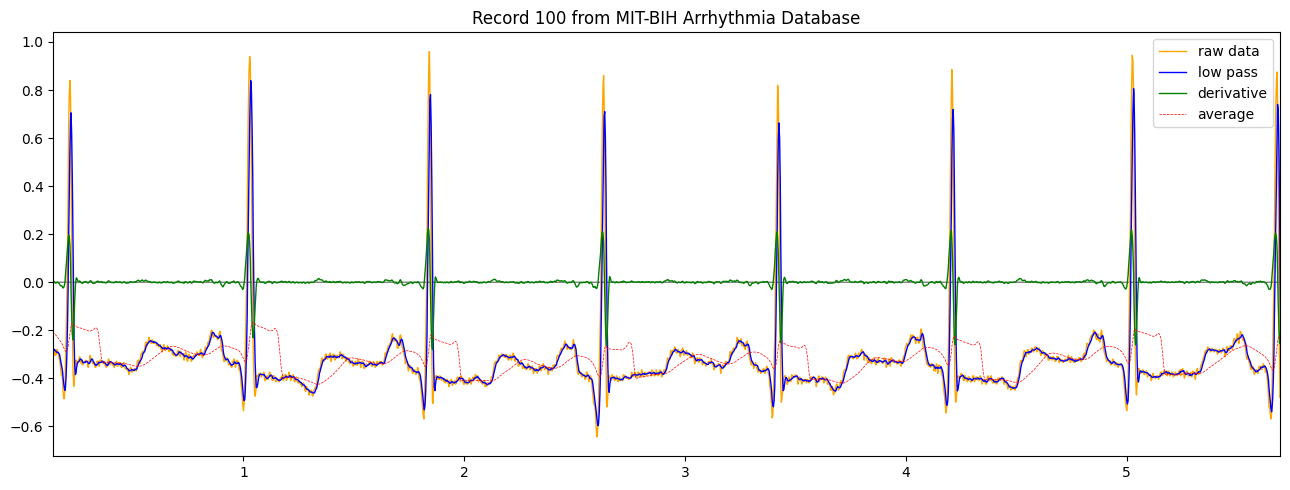

In [37]:
# Plot results

# Number of samples to plot (PLOT_SIZE+MEAN_WINDOW < SAMPLE_NUM)
PLOT_SIZE = 2000

plt.rcParams["figure.figsize"] = (13,5)
plt.title('Record 100 from MIT-BIH Arrhythmia Database')
plt.plot(v_time, axis_x, linewidth=0.5, color="black")
plt.plot(v_time, v_data, label="raw data", color="orange", linewidth=1)
plt.plot(v_time, v_data_lp, label="low pass", color="blue", linewidth=1)
plt.plot(v_time, v_data_deriv, label="derivative", color="green", linewidth=1)
plt.plot(v_time, v_mean, linestyle="--", color="red", linewidth=0.5, label="average")

# Set axes limits
ax = plt.gca()
ax.set_xlim([v_time[MEAN_WINDOW], v_time[MEAN_WINDOW+PLOT_SIZE]])
#ax.set_ylim([ymin, ymax])

plt.legend()
plt.tight_layout()
plt.show()

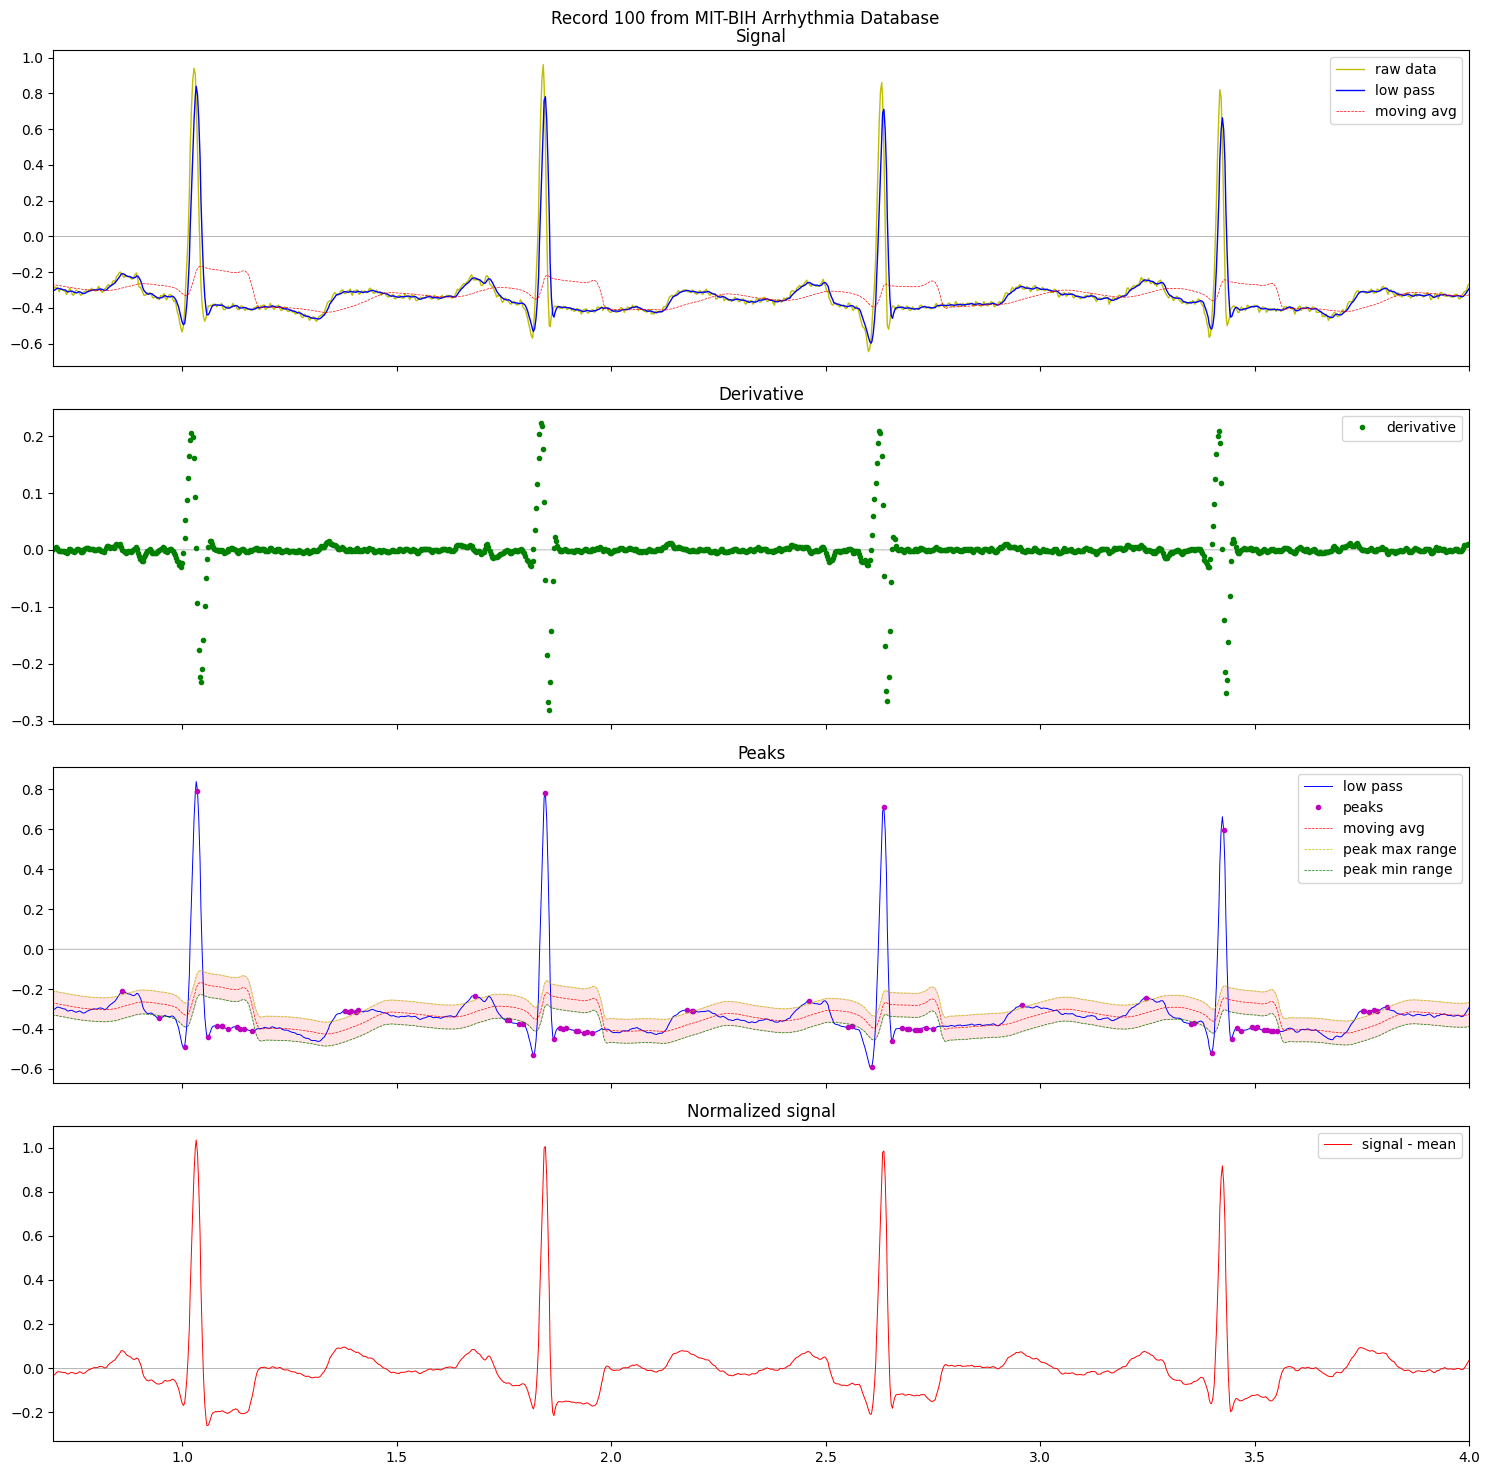

In [38]:
# Plotting window
X_MIN = 0.7
X_MAX = 4.0

# Create plots
fig, axs = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(15, 15)
fig.suptitle("Record 100 from MIT-BIH Arrhythmia Database")
axs[0].set_xlim(X_MIN, X_MAX)

# First plot
axs[0].title.set_text('Signal')
axs[0].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[0].plot(v_time, v_data, 'y' ,label="raw data", linewidth=1)
axs[0].plot(v_time, v_data_lp, 'b-', label="low pass", linewidth=1)
axs[0].plot(v_time, v_mean, 'r--', linewidth=0.5, label="moving avg")
axs[0].legend()

# Second plot
axs[1].title.set_text('Derivative')
axs[1].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[1].plot(v_time, v_data_deriv, '.', label="derivative", color="green", linewidth=1)
axs[1].legend()

# Third plot
axs[2].title.set_text('Peaks')
axs[2].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[2].plot(v_time, v_data_lp, 'b-', label="low pass", linewidth=0.7)
axs[2].plot(v_peaks_x, v_peaks_y, 'm.', label="peaks")
axs[2].plot(v_time, v_mean, 'r--', linewidth=0.5, label="moving avg")
axs[2].plot(v_time, v_mean_coef_pos, 'y--', linewidth=0.5, label="peak max range")
axs[2].plot(v_time, v_mean_coef_neg, 'g--', linewidth=0.5, label="peak min range")
axs[2].fill_between(v_time, v_mean_coef_pos, v_mean_coef_neg, color='red', alpha=0.1)
axs[2].legend()

# Fourth plot
axs[3].title.set_text('Normalized signal')
axs[3].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[3].plot(v_time, v_data_norm, 'r-', label="signal - mean", linewidth=0.7)
axs[3].legend()


plt.tight_layout()
plt.show()